# <p style ="padding: 10px; background-color: #1E90FF; color : #F8F8FF; font-family: newtimeroman; font-size: 150%; text-align: center; border-radius : 25px 25px;"> Are Sequels Better Than the Original? </p>

<p style = "text-align: center; font-family : newtimeroman; font-size: 125%;">
<strong> Justin Cheigh, Daisuke Yamada <br>
<strong> DIS Copenhagen, Spring 2023 <br> 
<strong> Computational Analysis of Big Data Final Project </p>
    
<p style = "text-align: justify;"> 
In this notebook we attempt to answer the question of whether sequels are better than the original. Our dataset comes from <a href="https://www.kaggle.com/datasets/shivam2503/diamonds"> kaggle,</a> and it contains 50,000 movie reviews (as strings) labeled "positive" or "negative". We begin by some initial preprocessing and data visualization. Afterwards we use GloVe embeddings to embed our review strings into a List[int] (with length 100). We tried a few different models. The main two (implemented by scratch in Keras) are a bidirectional LSTM (add citation) and a transformer. We also tried various base models (some classical ML models like random forest classifiers and some base transformer models from Hugging Face's transformers library). (UPDATE LATER).
    
<a id='top'></a>

# <p style ="padding: 10px; background-color: #1E90FF; color : #F8F8FF; font-family: newtimeroman; font-size: 100%; text-align: center; border-radius : 25px 25px;"> Table of Contents (UPDATE LATER) </p> 
|No  | Contents |No  | Contents  |
|:---| :---     |:---| :----     |
|1   | [<font color="#1c1c1c"> Importing Libraries</font>](#1)                   |8   | [<font color="#1c1c1c"> Model 4- Base DistilBERT </font>](#8)                   |
|2   | [<font color="#1c1c1c"> Importing/Splitting Data </font>](#2)                         |9   | [<font color="#1c1c1c"> Diamond's Depth Percentage </font>](#9)     
|3   | [<font color="#1c1c1c"> Data Visualization </font>](#3)                     |10   | [<font color="#1c1c1c"> Diamond's Table</font>](#10)   |  
|4   | [<font color="#1c1c1c"> GloVe Embeddings</font>](#4)                       |11  | [<font color="#1c1c1c"> Detecting Outliers</font>](#11)|   
|5   | [<font color="#1c1c1c"> Model 1- Bidirectional LSTM </font>](#5)      |12  | [<font color="#1c1c1c"> Correlation Map</font>](#12)   |         
|6   | [<font color="#1c1c1c"> Model 2- Base Transformer </font>](#6)              |13  | [<font color="#1c1c1c"> Model Creation </font>](#13)    |   
|7   | [<font color="#1c1c1c"> Model 3- Base Random Forest Classifier </font>](#7)           |14  | [<font color="#1c1c1c"> Final Model</font>](#14)  |     

<a id='1'></a>

# <p style ="padding: 10px; background-color: #1E90FF; color : #F8F8FF; font-family: newtimeroman; font-size: 100%; text-align: center; border-radius : 25px 25px;"> Importing Libraries </p>

In [2]:
# data analysis libraries 
import numpy as np
import pandas as pd

# data visualization libraries 
import matplotlib.pyplot as plt
import seaborn as sns 
from wordcloud import WordCloud
from wordcloud import STOPWORDS

# preprocessing 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# tensorflow/keras 
import tensorflow as tf
from tensorflow import keras 

# tokenization/embedding 
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

# keras models, layers, regularizers 
from keras.models import Sequential, load_model
from keras import layers
from keras.regularizers import l2

# torch, transformers
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from transformers import BertModel, BertTokenizer
from torch import nn
from transformers import pipeline

import gensim
import nltk
from gensim.models import Word2Vec
# other 
from tqdm import tqdm
import spacy
import re

import warnings
warnings.filterwarnings('ignore')

import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

<a id='2'></a>

# <p style ="padding: 10px; background-color: #1E90FF; color : #F8F8FF; font-family: newtimeroman; font-size: 100%; text-align: center; border-radius : 25px 25px;"> Importing/Splitting Data </p>

In [29]:
def get_data():
    train = pd.read_csv("train.csv")
    test = pd.read_csv("test.csv")

    # {positive, negative} -> {1, 0}
    label_encoder = LabelEncoder()
    train["sentiment"] = label_encoder.fit_transform(train["sentiment"])
    test["sentiment"] = label_encoder.fit_transform(test["sentiment"])

    # Split into train, test, val
    X_train, y_train = train["text"], train["sentiment"]
    X_test, y_test = test["text"], test["sentiment"]

    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size = .7, random_state = 101)
    return X_train, y_train, X_test, y_test, X_val, y_val

X_train, y_train, X_test, y_test, X_val, y_val = get_data()

<a id='3'></a>

# <p style ="padding: 10px; background-color: #1E90FF; color : #F8F8FF; font-family: newtimeroman; font-size: 100%; text-align: center; border-radius : 25px 25px;"> Data Visualization </p>

In [4]:
# List[String] of reviews 
text = list(train["text"]) + list(test["text"])

def get_reviews_from_label(dataframes, label):
    """
    Take List of dataframes and return all reviews 
    with df["sentiment"] == label in the form of 
    one string. 
    """
    result = ""
    for df in dataframes:
        lst_of_reviews = df[df["sentiment"] == label]["text"]
        review_string = " ".join(lst_of_reviews)
        result += review_string 
    return result

good_reviews = get_reviews_from_label([train, test], 1)
bad_reviews = get_reviews_from_label([train, test], 0)

In [45]:
def create_wordcloud(text, title):
    stop_words = STOPWORDS.update(["br", "film", "movie"])
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(text)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.title(title)
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

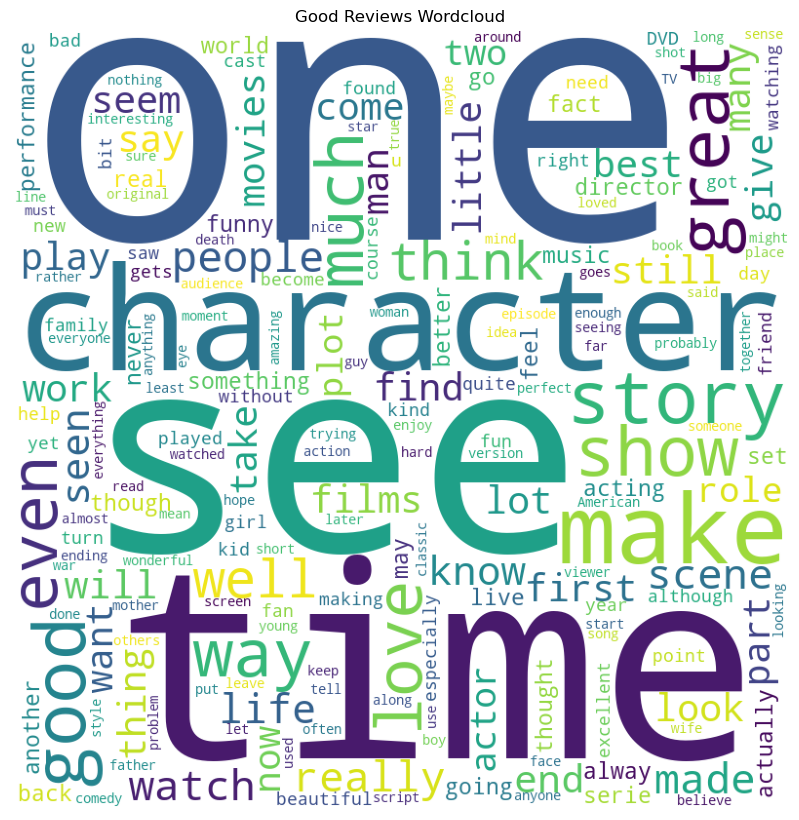

In [22]:
create_wordcloud(good_reviews, "Good Reviews Wordcloud")

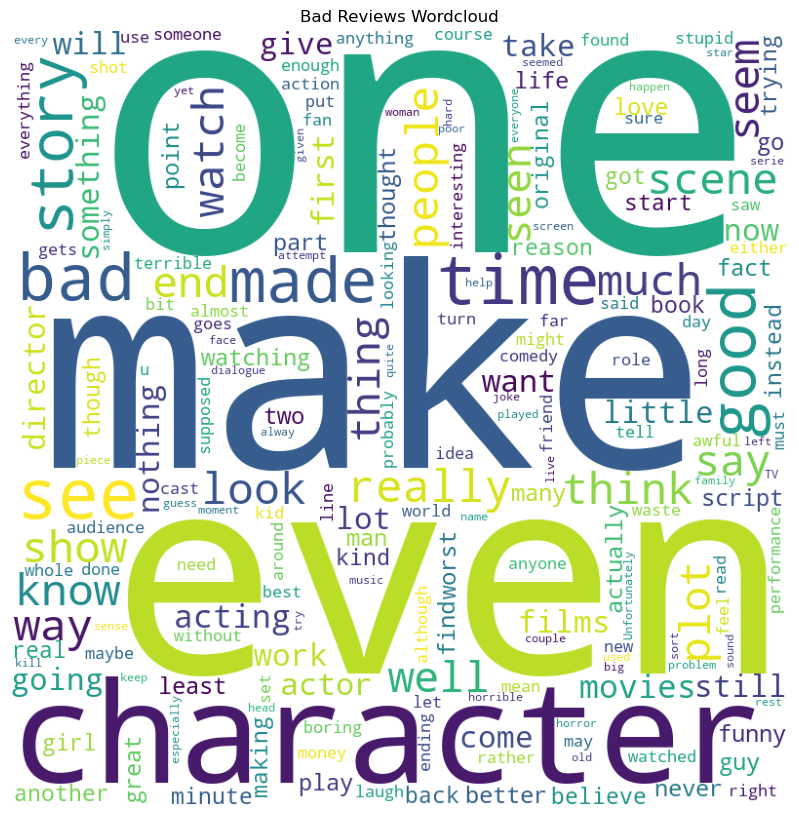

In [23]:
create_wordcloud(bad_reviews, "Bad Reviews Wordcloud")

Other visualization- number of characters in text,

In [42]:
random_rows = train.sample(2, random_state = 101)

sentiment_map = {0: "Negative Review", 1: "Positive Review"}
random_rows['sentiment'] = random_rows["sentiment"].map(sentiment_map)

for _, row in random_rows.iterrows():
    print(f"Sentiment- {row['sentiment']}:\n")
    print(f"Text: {row['text']}\n \n")

Sentiment- Positive Review:

Text: To all the haters out there: condemning a TV series with one episode is like judging an entire book after reading the first few pages. That being said, I was a huge fan of BSG, thought it was some of the best TV drama (not just sci-fi) on the air. But it was time for it to end and the story to move on. I liked the BSG epilogue "The Plan", but it raised as many new questions as it answered, so I eagerly anticipated "Caprica" and I was not disappointed.<br /><br />I was hoping it would not try to be another BSG, and I was pleased that "Caprica" is something different, and I personally found the story exciting, in a different way than blazing space battles, explosions and sci-fi special effects (don't get me wrong, I like that stuff too). Eric Stolz and Esai Morales give solid performances, and Alessandra was just wonderful. I can't wait until next week.
 

Sentiment- Negative Review:

Text: Can you say "All shock, no plot?" There were so many unexplored

In [27]:
print(f'Train: {len(X_train)} reviews')
print(f"Test: {len(X_test)} reviews")
print(f"Validation: {len(X_val)} reviews")

Train: 25000 reviews
Test: 17500 reviews
Validation: 7500 reviews


<a id='4'></a>

# <p style ="padding: 10px; background-color: #1E90FF; color : #F8F8FF; font-family: newtimeroman; font-size: 100%; text-align: center; border-radius : 25px 25px;"> GloVe Embeddings </p>

In [55]:
"""Tokenization: option 1 is GloVe embedding"""

'Tokenization: option 1 is GloVe embedding'

In [5]:
num_words = max([len(t.split()) for t in text], key=int)
tokenizer = Tokenizer(num_words = num_words, oov_token="<OOV>") 
tokenizer.fit_on_texts(text)
word_index = tokenizer.word_index
print(f"There are {len(word_index)} words in the text.")

There are 124253 words in the text.


In [6]:
def process(X, seqlen = 100):
    X = tokenizer.texts_to_sequences(X)
    return pad_sequences(X, maxlen = seqlen,
                         padding = "post",
                         truncating= "post")

X_train = process(X_train)
X_test = process(X_test)
X_val = process(X_val)

In [7]:
embedding = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        embedding[word] = vec

print(f'GloVe embedding has {len(embedding)} words.')

GloVe embedding has 400000 words.


In [8]:
seqlen = 100 
embedding_matrix = np.zeros((len(word_index)+1, seqlen))

for word, i in word_index.items():
    if word in embedding:
        vec = embedding[word]
        embedding_matrix[i] = vec

print('The embedding matrix has shape of', embedding_matrix.shape)

The embedding matrix has shape of (124254, 100)


In [11]:
embedding_layer = layers.Embedding(
    input_dim=len(word_index) + 1,
    output_dim=seqlen,
    weights=[embedding_matrix],
    input_length=seqlen,
    trainable=False)

<a id='5'></a>

# <p style ="padding: 10px; background-color: #1E90FF; color : #F8F8FF; font-family: newtimeroman; font-size: 100%; text-align: center; border-radius : 25px 25px;"> Model 1- Bidirectional LSTM </p>

In [142]:
# MODEL 1- Bidirectional LSTM
# define embedding layer (non-trainable)

# define our model
model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(128, return_sequences=True)), 
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(5, activation="softmax")
])

# complie the model
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy']
)

In [144]:
# train the model
model.fit(X_train, y_train, batch_size=100, epochs=10, validation_data=(X_val, y_val), validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 80s 309ms/step - loss: 0.6942 - accuracy: 0.5621 - val_loss: 0.6217 - val_accuracy: 0.6727
Epoch 2/10
250/250 [==============================] - 76s 304ms/step - loss: 0.5475 - accuracy: 0.7213 - val_loss: 0.4943 - val_accuracy: 0.7525
Epoch 3/10
250/250 [==============================] - 76s 302ms/step - loss: 0.4815 - accuracy: 0.7668 - val_loss: 0.4611 - val_accuracy: 0.7804
Epoch 4/10
250/250 [==============================] - 76s 305ms/step - loss: 0.4540 - accuracy: 0.7829 - val_loss: 0.4413 - val_accuracy: 0.7859
Epoch 5/10
250/250 [==============================] - 77s 307ms/step - loss: 0.4319 - accuracy: 0.7965 - val_loss: 0.4292 - val_accuracy: 0.7959
Epoch 6/10
250/250 [==============================] - 80s 321ms/step - loss: 0.4095 - accuracy: 0.8097 - val_loss: 0.4181 - val_accuracy: 0.8001
Epoch 7/10
250/250 [==============================] - 77s 309ms/step - loss: 0.3948 - accuracy: 0.8188 - val_loss: 0.4096 - val_ac

In [146]:
model.save('saved_models/bidirectional_lstm')

INFO:tensorflow:Assets written to: saved_models/bidirectional_lstm/assets


INFO:tensorflow:Assets written to: saved_models/bidirectional_lstm/assets


In [24]:
model = load_model('saved_models/bidirectional_lstm')

2023-04-18 17:37:15.389493: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
# evaluate on the current version
score = model.evaluate(X_test, y_test)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

547/547 [==============================] - 27s 48ms/step - loss: 0.4143 - accuracy: 0.8129
Test loss : 0.4143354296684265
Test accuracy : 0.8128571510314941


<a id='6'></a>

# <p style ="padding: 10px; background-color: #1E90FF; color : #F8F8FF; font-family: newtimeroman; font-size: 100%; text-align: center; border-radius : 25px 25px;"> Model 2- Base Transformer </p>

In [15]:
#https://alvinntnu.github.io/NTNU_ENC2045_LECTURES/nlp/dl-transformers-keras.html
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)  # self-attention layer
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # layer norm
        ffn_output = self.ffn(out1)  #feed-forward layer
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # layer norm

In [16]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size,
                                          output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [22]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
maxlen = 100
vocab_size = len(word_index)

## Using Sequential API
model = keras.Sequential()
model.add(layers.Input(shape=(maxlen, )))
model.add(TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim))
model.add(TransformerBlock(embed_dim, num_heads, ff_dim))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(ff_dim, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [27]:
model.compile(optimizer="adam",
              loss= "binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train,
                    y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(X_val, y_val))

Epoch 1/10
196/196 [==============================] - 13s 63ms/step - loss: 0.5208 - accuracy: 0.7277 - val_loss: 0.4191 - val_accuracy: 0.8056
Epoch 2/10
196/196 [==============================] - 12s 62ms/step - loss: 0.3859 - accuracy: 0.8280 - val_loss: 0.4252 - val_accuracy: 0.8005
Epoch 3/10
196/196 [==============================] - 12s 62ms/step - loss: 0.3623 - accuracy: 0.8390 - val_loss: 0.4088 - val_accuracy: 0.8080
Epoch 4/10
196/196 [==============================] - 12s 62ms/step - loss: 0.3538 - accuracy: 0.8441 - val_loss: 0.4454 - val_accuracy: 0.7932
Epoch 5/10
196/196 [==============================] - 12s 63ms/step - loss: 0.3414 - accuracy: 0.8458 - val_loss: 0.4266 - val_accuracy: 0.8000
Epoch 6/10
196/196 [==============================] - 12s 63ms/step - loss: 0.3334 - accuracy: 0.8474 - val_loss: 0.4419 - val_accuracy: 0.8013
Epoch 7/10
196/196 [==============================] - 12s 62ms/step - loss: 0.3190 - accuracy: 0.8513 - val_loss: 0.4421 - val_accuracy:

In [28]:
model.save('saved_models/transformer')

INFO:tensorflow:Assets written to: saved_models/transformer/assets


INFO:tensorflow:Assets written to: saved_models/transformer/assets


<a id='7'></a>

# <p style ="padding: 10px; background-color: #1E90FF; color : #F8F8FF; font-family: newtimeroman; font-size: 100%; text-align: center; border-radius : 25px 25px;"> Model 3- Base Random Forest Classifier </p>

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

n_estimators=[64,100,128,200]
max_features= [2,3,4]
bootstrap = [True,False]
oob_score = [True,False]

param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap,
             'oob_score':oob_score}  # Note, oob_score only makes sense when bootstrap=True!

rfc = RandomForestClassifier()
grid = GridSearchCV(rfc,param_grid)

grid.fit(X_train,y_train)
grid.best_params_


{'bootstrap': True, 'max_features': 4, 'n_estimators': 200, 'oob_score': True}

In [42]:
train_predictions = grid.predict(X_train)
print(classification_report(y_train, train_predictions))

test_predictions = grid.predict(X_test)
print(classification_report(y_test, test_predictions))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12500
           1       1.00      1.00      1.00     12500

    accuracy                           1.00     25000
   macro avg       1.00      1.00      1.00     25000
weighted avg       1.00      1.00      1.00     25000

              precision    recall  f1-score   support

           0       0.53      0.56      0.54      8682
           1       0.54      0.51      0.53      8818

    accuracy                           0.53     17500
   macro avg       0.53      0.53      0.53     17500
weighted avg       0.54      0.53      0.53     17500



In [12]:
model = pipeline('sentiment-analysis', framework='pt', model='distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

In [31]:
X_train, y_train, X_test, y_test, X_val, y_val = get_data()

def get_predictions(X):
    predictions = []
    for review in X:
        sentiment = model(review)[0]
        predictions.append(sentiment)
    return predictions

get_predictions(X_train)

Token indices sequence length is longer than the specified maximum sequence length for this model (735 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: The size of tensor a (735) must match the size of tensor b (512) at non-singleton dimension 1

In [32]:
X_train

0        Now, I won't deny that when I purchased this o...
1        The saddest thing about this "tribute" is that...
2        Last night I decided to watch the prequel or s...
3        I have to admit that i liked the first half of...
4        I was not impressed about this film especially...
                               ...                        
24995    This film is fun, if your a person who likes a...
24996    After seeing this film I feel like I know just...
24997    first this deserves about 5 stars due to actin...
24998    If you like films that ramble with little plot...
24999    As interesting as a sheet of cardboard, this d...
Name: text, Length: 25000, dtype: object

1. Clean up whole notebook
2. get sequel
3. analyze sequel data 
4. blog 